In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [2]:
df = pd.read_csv('data\gemstone.csv')
print(df.shape)

(193573, 11)


In [3]:
df.drop('id', axis=1, inplace=True)

In [4]:
X = df.drop('price', axis=1)
y = df['price']

In [23]:
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(exclude='object').columns
            
cut_categories = ['Fair', 'Good', 'Very Good','Premium','Ideal']
color_categories = ['D', 'E', 'F', 'G', 'H', 'I', 'J']
clarity_categories = ['I1','SI2','SI1','VS2','VS1','VVS2','VVS1','IF']

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder,StandardScaler

num_pipeline = Pipeline(
                steps = [
                ('imputer',SimpleImputer(strategy='median')),
                ('scaler',StandardScaler())                
                ]
            )

cat_pipeline = Pipeline(
                steps=[
                ('imputer',SimpleImputer(strategy='most_frequent')),
                ('ordinal_encoder',OrdinalEncoder(categories=[cut_categories,color_categories,clarity_categories])),
                ('scaler',StandardScaler())
                ]
            )

preprocessor = ColumnTransformer(
                [
                ('num_pipeline',num_pipeline,numerical_cols),
                ('cat_pipeline',cat_pipeline,categorical_cols)
                ]
            )

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_test.shape)

(154858, 9) (38715,)


In [25]:
X_train = pd.DataFrame(preprocessor.fit_transform(X_train),columns=preprocessor.get_feature_names_out())
X_test = pd.DataFrame(preprocessor.transform(X_test),columns=preprocessor.get_feature_names_out())

In [12]:
df.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z',
       'price'],
      dtype='object')

In [18]:
numerical_columns = X.select_dtypes(exclude='object').columns.to_list()
categorical_columns = X.select_dtypes(include='object').columns.to_list()

In [26]:
preprocessor.get_feature_names_out()

array(['num_pipeline__carat', 'num_pipeline__depth',
       'num_pipeline__table', 'num_pipeline__x', 'num_pipeline__y',
       'num_pipeline__z', 'cat_pipeline__cut', 'cat_pipeline__color',
       'cat_pipeline__clarity'], dtype=object)

In [27]:
X_train.head()

,num_pipeline__carat,num_pipeline__depth,num_pipeline__table,num_pipeline__x,num_pipeline__y,num_pipeline__z,cat_pipeline__cut,cat_pipeline__color,cat_pipeline__clarity
0,-1.016395,-0.204317,0.402608,-1.202472,-1.187395,-1.194148,-0.132842,-0.936018,-0.648950
1,0.882396,0.720758,-0.118536,0.985177,0.941823,1.036109,-0.132842,-0.320002,0.017052
2,1.529711,0.350728,-1.160823,1.426308,1.394848,1.441611,0.872563,1.528047,0.017052
3,1.896523,0.073206,0.923751,1.741402,1.711965,1.702290,-0.132842,1.528047,-1.314953
4,0.450852,1.738340,1.444895,0.562052,0.525040,0.703019,-2.143651,0.912031,0.017052


In [28]:
X_test.head()

,num_pipeline__carat,num_pipeline__depth,num_pipeline__table,num_pipeline__x,num_pipeline__y,num_pipeline__z,cat_pipeline__cut,cat_pipeline__color,cat_pipeline__clarity
0,-0.628006,0.258221,-0.118536,-0.599293,-0.580341,-0.571414,0.872563,-1.552034,-0.648950
1,2.608569,-2.146973,-0.118536,2.128516,2.201232,1.962969,-1.138246,0.296015,-1.314953
2,-1.124281,-1.221899,0.923751,-1.373523,-1.413907,-1.469310,-0.132842,-0.936018,2.015061
3,-1.016395,-0.574346,0.923751,-1.157458,-1.160213,-1.194148,-0.132842,1.528047,2.015061
4,0.860819,0.628251,-0.639679,0.949167,0.987125,1.007145,0.872563,0.912031,-0.648950


In [29]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [32]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}

model_list = []
r2_list = []

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
    model_test_mae, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)
    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 1016.9490
- Mean Absolute Error: 677.1656
- R2 Score: 0.9366
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1006.6010
- Mean Absolute Error: 671.5856
- R2 Score: 0.9373


Lasso
Model performance for Training set
- Root Mean Squared Error: 1017.0718
- Mean Absolute Error: 678.3145
- R2 Score: 0.9366
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1006.8716
- Mean Absolute Error: 672.8635
- R2 Score: 0.9373


Ridge
Model performance for Training set
- Root Mean Squared Error: 1016.9491
- Mean Absolute Error: 677.1925
- R2 Score: 0.9366
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1006.6062
- Mean Absolute Error: 671.6137
- R2 Score: 0.9373


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 545.6563
- Mean Absolute Error: 285.8181
- R2 Sco

In [33]:
df_results = pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=['R2_Score'], ascending=False)
df_results

,Model Name,R2_Score
7,CatBoosting Regressor,0.979186
6,XGBRegressor,0.978790
5,Random Forest Regressor,0.977148
3,K-Neighbors Regressor,0.972114
4,Decision Tree,0.957196
0,Linear Regression,0.937298
2,Ridge,0.937297
1,Lasso,0.937264
8,AdaBoost Regressor,0.893431


In [34]:
cbr = CatBoostRegressor(verbose=False)

params = {'depth': [4,5,6,7,8,9, 10],'learning_rate': [0.01,0.02,0.03,0.04],'iterations': [300,400,500,600]}

rscv = RandomizedSearchCV(cbr, params, scoring='r2', cv=5, n_jobs=-1)

rscv.fit(X_train, y_train)

print(rscv.best_params_)
print(rscv.best_score_)

{'learning_rate': 0.04, 'iterations': 600, 'depth': 10}
0.9797589710656496


In [35]:
def print_evaluated_results(model,xtrain,ytrain,xtest,ytest):
    ytrain_pred = model.predict(xtrain)
    ytest_pred = model.predict(xtest)

    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(ytrain, ytrain_pred)
    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(ytest, ytest_pred)

    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))

In [36]:
best_cbr = rscv.best_estimator_

print_evaluated_results(best_cbr, X_train, y_train, X_test, y_test)

Model performance for Training set
- Root Mean Squared Error: 533.2828
- Mean Absolute Error: 283.9554
- R2 Score: 0.9826
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 576.4708
- Mean Absolute Error: 294.4453
- R2 Score: 0.9794


num_pipeline__carat      22.386454
cat_pipeline__clarity    19.076315
num_pipeline__y          15.432402
num_pipeline__x          15.364236
cat_pipeline__color      13.286882
num_pipeline__z          13.136883
cat_pipeline__cut         0.553278
num_pipeline__table       0.410749
num_pipeline__depth       0.352802
dtype: float64




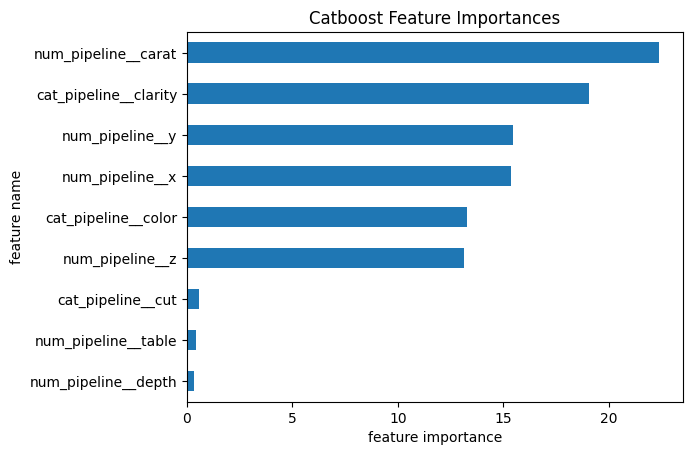

In [37]:
feature_imp = best_cbr.feature_importances_
feature_nm = best_cbr.feature_names_
imp_series = pd.Series(feature_imp)
imp_series.index = feature_nm
print(imp_series.sort_values(ascending=False))
print('\n')
imp_series.sort_values().plot(kind='barh', xlabel='feature importance', ylabel='feature name', title='Catboost Feature Importances')
plt.show()